# Extracting Signatures from Document Images Using CRAFT and MobileNet-v3-small

This notebook demonstrates the process of extracting signatures from scanned or photographed document images using deep learning techniques. It utilizes CRAFT as a text detection model to identify all text regions (both signatures and non-signatures) within an image. These text regions are cropped and fed into a MobileNet-v3-small model, which classifies each cropped image as either a signature or not. Finally, bounding boxes are drawn around the detected signatures.

## 1. Imports

In [1]:
import os
import time
import torch
import torch.nn as nn
from PIL import Image
import cv2
from skimage import io
import numpy as np
from craft import CRAFT
from craft_test import test_net, copyStateDict
from torchvision import models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import os
import shutil

## 2. Define Utility Functions

This section introduces three utility functions:

- load_style_classifier: Loads a **MobileNetV3 Small** model with specified weights for binary classification, configures the model in evaluation mode and returns the model, image transformation pipeline, and the device to be used (GPU or CPU).

- predict_image_evaluation: Takes an image array as input and applies the necessary transformations to the image then predicts whether the text is **signature** or **non-signature** using the specified model and device. it then returns the predicted class name and the confidence score.

- text_detection_and_classification: Detects text regions in images from a specified folder. Classifies each detected region as **signature** or **non-signature** then saves the results, including bounding boxes and classifications, to the output folder.


In [9]:
def load_style_classifier(weights_path):
    """
    @info: Loads a MobileNetV3 Small model for binary classification, configures it with specified weights, sets it to evaluation mode, and prepares a transformation pipeline for preprocessing images.
    @inputs:
        - weights_path (str): Path to the pre-trained weights file.
    @outputs:
        - mobilenet_model (torch.nn.Module): The loaded and configured MobileNetV3 Small model.
        - transform (torchvision.transforms.Compose): Transformation pipeline for image preprocessing.
        - device (torch.device): Device (CPU or GPU) on which the model will run.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    mobilenet_model = models.mobilenet_v3_small(pretrained=False)
    mobilenet_model.classifier[3] = nn.Linear(mobilenet_model.classifier[3].in_features, 2)  # Assuming binary classification
    mobilenet_model.load_state_dict(torch.load(weights_path, map_location=device))
    mobilenet_model = mobilenet_model.to(device)
    mobilenet_model.eval()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return mobilenet_model, transform, device


def predict_image_evaluation(image_array, model, transform, device):
    """
    @info: Predicts the class of a given image as either 'Signature' or 'Non-Signature' using a pre-trained model. Preprocesses the image and returns the predicted class name along with the confidence score.
    @inputs:
        - image_array (numpy.ndarray): The input image in numpy array format (BGR format as from OpenCV).
        - model (torch.nn.Module): The pre-trained model for classification.
        - transform (torchvision.transforms.Compose): Transformation pipeline for image preprocessing.
        - device (torch.device): Device (CPU or GPU) on which the model runs.
    @outputs:
        - predicted_class (str): The predicted class name ('Signature' or 'Non-Signature').
        - confidence (float): Confidence score of the prediction.
    """
    class_names = ['Signature', 'Non-Signature']
    
    if image_array.size == 0:
        raise ValueError("Empty image array passed to predict_image function.")
    
    # Convert image to RGB and then to a PIL image
    image = Image.fromarray(cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB))
    
    # Apply transformations and prepare the image for the model
    image = transform(image).unsqueeze(0).to(device)
    
    # Perform prediction
    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, dim=1)
    
    # Return the predicted class and the confidence score
    return class_names[predicted.item()], confidence.item()


In [11]:
def Text_Detection_and_Classification(test_folder, result_folder, weights_path):
    """
    @info: Detects text regions in images from a specified folder, classifies each detected region as 'Signature' or 'Non-Signature' using a pre-trained MobileNetV3 Small model, and saves the results with bounding boxes and classifications to the output folder.
    @inputs:
        - test_folder (str): Path to the folder containing test images.
        - result_folder (str): Path to the folder where results will be saved.
        - weights_path (str): Path to the weights file for the classification model.
    @outputs:
        - Saves processed images with bounding boxes and classifications to the result folder.
        - Prints the average inference time per document.
    """
    trained_model = 'craft_mlt_25k.pth'
    text_threshold = 0.05
    low_text = 0.2
    link_threshold = 0.15
    use_cuda = False
    canvas_size = 1280
    mag_ratio = 1.5
    poly = False
    show_time = False
    refine = False

    # Load the pre-trained CRAFT text detection model
    net = CRAFT()
    net.load_state_dict(copyStateDict(torch.load(trained_model, map_location=torch.device('cpu'))))
    net.eval()  # Set the model to evaluation mode

    # Load the pre-trained MobileNetV3 Small model for text classification
    mobilenet_model, transform, device = Load_Style_Classifier(weights_path)

    # Create result folder if it doesn't exist
    if not os.path.exists(result_folder):
        os.makedirs(result_folder)

    # Load image paths from the test folder
    image_list = [os.path.join(test_folder, img) for img in os.listdir(test_folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    img_num = 0
    start_time = time.time()

    # Process each image in the folder
    for k, image_path in enumerate(image_list):
        img_num += 1
        image = cv2.imread(image_path)
        
        # Detect text in the image
        bboxes, polys, score_text = test_net(net, image, text_threshold, link_threshold, low_text, use_cuda, poly, canvas_size, mag_ratio, None)

        filename, file_ext = os.path.splitext(os.path.basename(image_path))
        
        # Save the text score map as an image
        mask_file = os.path.join(result_folder, "res_" + filename + '_mask.jpg')
        cv2.imwrite(mask_file, score_text)

        # Process each detected text box
        for i, bbox in enumerate(bboxes):
            x, y, w, h = cv2.boundingRect(np.array(bbox))
            cropped_image = image[y:y+h, x:x+w]

            # Skip if the cropped image is empty
            if cropped_image.size == 0:
                continue

            # Predict the class of the cropped text region
            predicted_class, confidence = predict_image_evaluation(cropped_image, mobilenet_model, transform, device)

            # Choose the bounding box color based on the predicted class
            color = (0, 255, 255)
            if predicted_class == "Signature":
                cv2.polylines(image, [np.array(bbox).astype(np.int32)], True, color, 2)

        # Save the result image with bounding boxes and classifications
        result_image_path = os.path.join(result_folder, f"{filename}_result{file_ext}")
        cv2.imwrite(result_image_path, image)
        
        # Convert image to RGB (OpenCV uses BGR by default) and display it using matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        plt.title(f"Result for Image Number {img_num}")
        plt.axis('off')  # Hide the axis
        plt.show()

    end_time = time.time()
    print(f"Average Inference time per document: {((end_time-start_time)/img_num):.2f} seconds")
    print("Processing completed.")


## 3. Extract Signature
By applying the full pipeline of text detection using CRAFT and classification of text extracted using MobilNet-v3-small 

C:\Users\ENGY\AppData\Local\Temp\ipykernel_4844\2047599540.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, m

Image shape: (448, 419, 3)


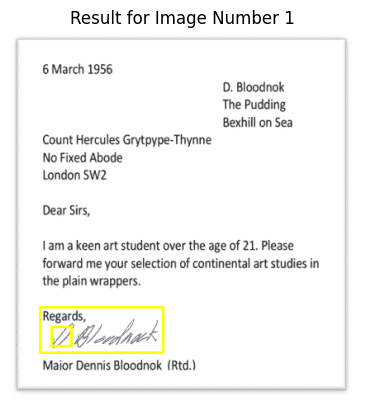

Image shape: (638, 414, 3)


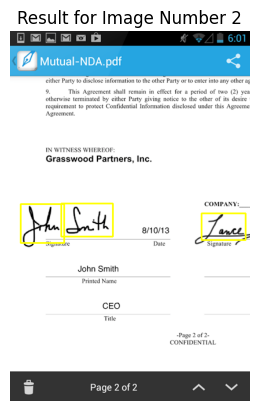

Image shape: (175, 577, 3)


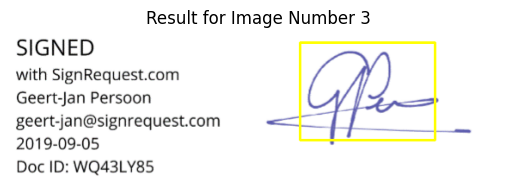

Image shape: (746, 1400, 3)


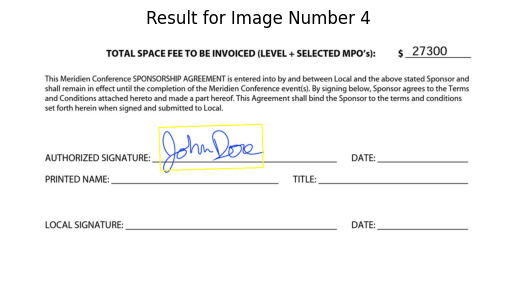

Image shape: (439, 435, 3)


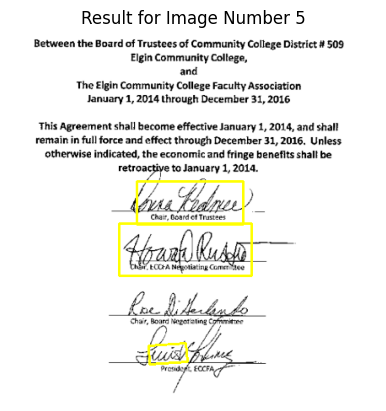

Image shape: (250, 360, 3)


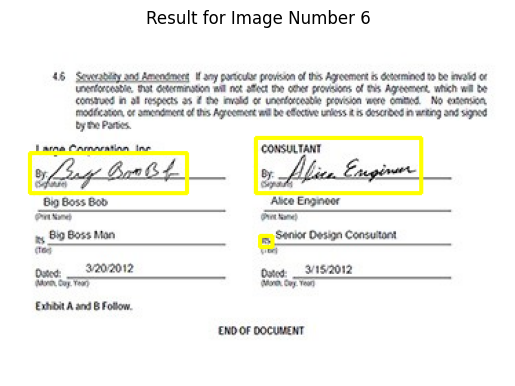

Image shape: (202, 235, 3)


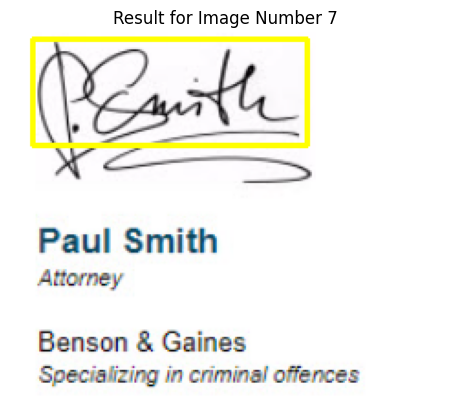

Image shape: (800, 800, 3)


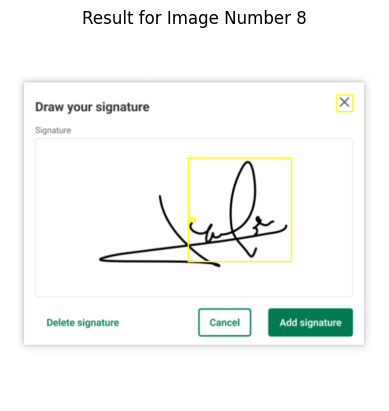

Average Inference time per document: 16.44 seconds
Processing completed.


In [12]:
weights_path = "Best_Model_Signatures/best_model_signatures.pth"
Text_Detection_and_Classification("./Test_Documents/","./Test_Documents_Results/", weights_path)